In [1]:
!pip install mljar-supervised
!pip install surprise
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.3/224.3 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.9 MB/s eta 0:00:00
  Created wheel for mljar-supervised: filename=mljar_supervised-0.11.5-py3-none-any.whl size=147049 sha256=c9a39e0100c6ebb3f1736fd6366fa7d829591cd104d64c8d6c8dd6071b6632e9
  Stored in directory: /root/.cache/pip/whee

In [2]:
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from supervised.automl import AutoML
from surprise import SVD, Dataset, Reader, accuracy
from surprise import SVDpp
from surprise import BaselineOnly
from surprise import accuracy

from surprise.model_selection import train_test_split



In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(69)

In [4]:

from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [5]:
path = '/content/gdrive/MyDrive/book'
train = pd.read_csv(f'{path}/train.csv')
test = pd.read_csv(f'{path}/test.csv')
ans = f'{path}/sample_submission.csv'

In [6]:
train.head()

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,TRAIN_000000,USER_00000,BOOK_044368,8,23.0,"sackville, new brunswick, canada",Road Taken,Rona Jaffe,2001.0,Mira
1,TRAIN_000001,USER_00000,BOOK_081205,8,23.0,"sackville, new brunswick, canada",Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books
2,TRAIN_000002,USER_00000,BOOK_086781,0,23.0,"sackville, new brunswick, canada",Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books
3,TRAIN_000003,USER_00000,BOOK_098622,0,23.0,"sackville, new brunswick, canada",Mother Earth Father Sky,Sue Harrison,1991.0,Avon
4,TRAIN_000004,USER_00000,BOOK_180810,8,23.0,"sackville, new brunswick, canada",She Who Remembers,Linda Lay Shuler,1989.0,Signet Book


In [7]:
test.head()

,ID,User-ID,Book-ID,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,TEST_000000,USER_00008,BOOK_047966,37.0,"vermilion, ohio, usa",Birds of Prey: A Novel of Suspense,J.A. Jance,2002.0,Avon
1,TEST_000001,USER_00008,BOOK_119494,37.0,"vermilion, ohio, usa",Midnight Voices,JOHN SAUL,2003.0,Ballantine Books
2,TEST_000002,USER_00008,BOOK_151775,37.0,"vermilion, ohio, usa",Breaking Free : A Prescription for Personal an...,David M. Noer,1996.0,Jossey-Bass
3,TEST_000003,USER_00008,BOOK_176255,37.0,"vermilion, ohio, usa",Bitter Harvest,Ann Rule,1999.0,Pocket
4,TEST_000004,USER_00008,BOOK_187307,37.0,"vermilion, ohio, usa",Embraced by the Light,Betty J. Eadie,1994.0,Bantam Books


In [8]:
cnt_0 = train['Book-Rating'].value_counts()
cnt_0

0     548804
8      76971
10     60024
7      55852
9      50494
5      38416
6      26670
4       6462
3       4374
2       2019
1       1307
Name: Book-Rating, dtype: int64

In [9]:
train_seg = train
train_seg['Rating-Seg'] = train_seg['Book-Rating'].replace(to_replace=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], value=1)

train_seg_deep = train
train_seg_deep = train_seg_deep[train_seg_deep['Book-Rating'] != 0]



In [10]:
train_seg_deep.head()

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher,Rating-Seg
0,TRAIN_000000,USER_00000,BOOK_044368,8,23.0,"sackville, new brunswick, canada",Road Taken,Rona Jaffe,2001.0,Mira,1
1,TRAIN_000001,USER_00000,BOOK_081205,8,23.0,"sackville, new brunswick, canada",Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books,1
4,TRAIN_000004,USER_00000,BOOK_180810,8,23.0,"sackville, new brunswick, canada",She Who Remembers,Linda Lay Shuler,1989.0,Signet Book,1
5,TRAIN_000005,USER_00000,BOOK_206799,5,23.0,"sackville, new brunswick, canada",Neuromancer (Remembering Tomorrow),William Gibson,1995.0,Ace Books,1
6,TRAIN_000006,USER_00000,BOOK_239414,9,23.0,"sackville, new brunswick, canada",The Little Prince,Antoine de Saint-ExupÃ©ry,1982.0,Harvest Books,1


In [11]:
train_seg['Rating-Seg'].value_counts()

0    548804
1    322589
Name: Rating-Seg, dtype: int64

In [12]:
train_seg_deep['Book-Rating'].value_counts()

8     76971
10    60024
7     55852
9     50494
5     38416
6     26670
4      6462
3      4374
2      2019
1      1307
Name: Book-Rating, dtype: int64

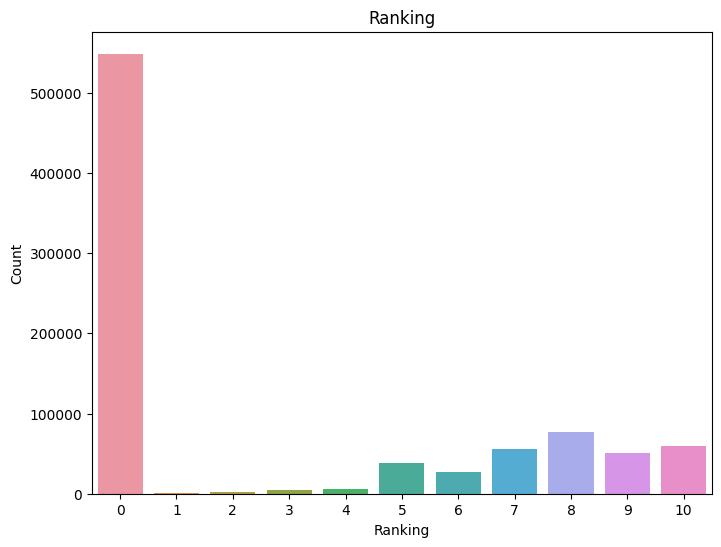

In [13]:
ds = train['Book-Rating'].value_counts().reset_index()

ds.columns = ['value', 'count']

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x='value', y='count', data=ds, ax=ax)
ax.set_title('Ranking')
ax.set_xlabel('Ranking')
ax.set_ylabel('Count')
plt.show()

### SVD

In [14]:
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise import NMF, SlopeOne, KNNBasic
from surprise.model_selection import cross_validate


In [15]:
#train_seg
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(train_seg[['User-ID', 'Book-ID', 'Book-Rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=69)
param_grid = {"n_epochs": [15], "lr_all": [0.006], "reg_all": [0.3]}
gsSVD_seg = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=75, n_jobs = -1, joblib_verbose=1, refit=True)


In [16]:
gsSVD_seg.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  9.8min finished


In [17]:
print(f'gsSVD_seg : {gsSVD_seg.best_score["rmse"]}')

gsSVD_seg : 3.4111726350184224


In [19]:
submit = pd.read_csv( f'{path}/sample_submission.csv')
submit['Book-Rating'] = test.apply(lambda row: gsSVD_seg.predict(row['User-ID'], row['Book-ID']).est, axis=1)

In [20]:
submit.to_csv('./baseline_submit.csv', index=False)